# Product image classification using deep learning methods

In this project, we aim to classify product images using deep learning techniques. The idea is to use a model that can look at an image of a product and determine what category the product belongs to. This project can be useful for businesses that need to classify products based on their images.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Path to the folder containing product images
image_folder = "C:/Pictures/"

# Load the Excel file into a Pandas DataFrame
excel_file = "C:/Pictures/product_list.xlsx"
data = pd.read_excel(excel_file)
data['Exist'] = 0

# Loop through each row in the DataFrame
for index, row in data.iterrows():
    # Get the barcode value for the current row
    barcode = str(row["Barcode"])
    
    # Construct the path to the image file using the barcode
    image_path = os.path.join(image_folder, barcode + ".jpg")
    
    # Check if the image file exists
    if os.path.exists(image_path):
        data['Exist'][index] = 1
        
#data.to_excel('exist_product_list.xlsx', index=False)
data = data[data['Exist']==1]

# Get the counts of each category
category_counts = data["Category"].value_counts()
# Filter the categories with less than 5 values
selected_categories = category_counts[category_counts >= 10].index.tolist()
# Filter the data to only include the selected categories
data = data[data["Category"].isin(selected_categories)]

# Define the categories
categories = data["Category"].unique()
# Convert the categories to numeric labels
category_labels = {category: label for label, category in enumerate(categories)}
data["Label"] = data["Category"].apply(lambda x: category_labels[x])
data= data[['Barcode','ProductDescription','Category','Manufacturer','Exist','Label']]
data = data.drop_duplicates()
data

<ipython-input-2-45300f88b6a1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Exist'][index] = 1


,Barcode,ProductDescription,Category,Manufacturer,Exist,Label
0,7290002333500,עדשים אדומות אורגני הרדוף 500 גרם,אורגני - אורז דגנים וקטניות,הרדוף,1,0
1,7290002333098,גרגירי חומוס אורגני הרדוף 500 גרם,אורגני - אורז דגנים וקטניות,הרדוף,1,0
2,7290011474478,זרעי צ'יה אורגניים תבואות 300 גרם,אורגני - אורז דגנים וקטניות,תבואות,1,0
3,7290011473211,עדשים אדומות אורגני תבואות 500 גרם,אורגני - אורז דגנים וקטניות,תבואות,1,0
4,7290011473181,עדשים שחורות אורגניים תבואות 500 גרם,אורגני - אורז דגנים וקטניות,תבואות,1,0
...,...,...,...,...,...,...
17648,8008857300634,פסטה קוואטאפי פסטה רג'יאה 500 גרם,פסטה ספגטי ולזניה,תומר - פסטה רג'יאה,1,11
17652,8008857300603,פסטה גומיטי ריגטה פסטה רג'יאה 500 גרם,פסטה ספגטי ולזניה,תומר - פסטה רג'יאה,1,11
17665,7290014356078,פסטה פנה שדות 500 גרם,פסטה ספגטי ולזניה,אחים אגא - שדות,1,11
17668,7290014356108,פסטה קרניים שדות 500 גרם,פסטה ספגטי ולזניה,אחים אגא - שדות,1,11


### EDA

In [3]:
data["Category"].value_counts()

פסטה ספגטי ולזניה              186
ופלים                          169
אורגני - אורז דגנים וקטניות    104
ביסקוויטים ופתי בר              85
גבינה מלוחה                     84
גבינה לבנה                      81
אורז                            67
אורגני - פסטה                   65
יוגורט                          62
נייר טואלט                      54
גבינות צאן                      44
גבינה חצי קשה                   26
Name: Category, dtype: int64

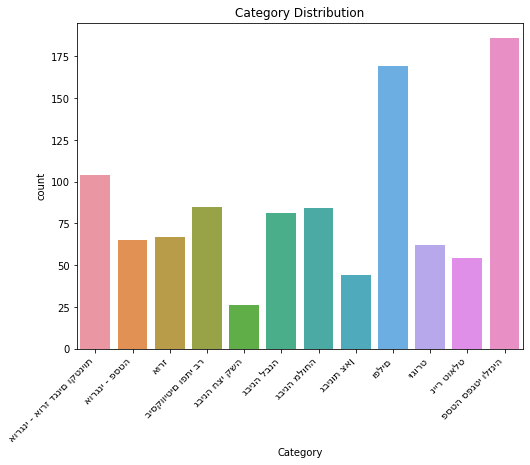

In [4]:
# Check the distribution of categories
plt.figure(figsize=(8, 6))
sns.countplot(x='Category', data=data)
plt.xticks(rotation=45, ha='right')
plt.title("Category Distribution")
plt.show()

We will display ne example product and its description from each category in a dataset.

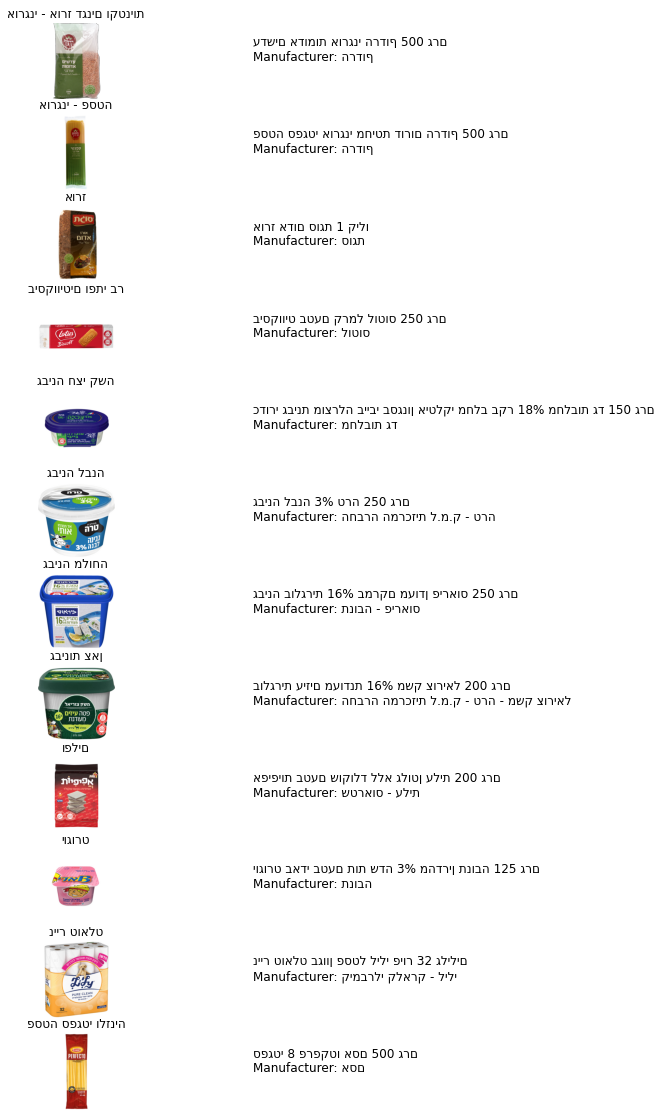

In [5]:
# Get one example product from each category
categories = data['Category'].unique()
examples = {}
for category in categories:
    examples[category] = data[data['Category']==category].iloc[0]

# Set up the figure
fig, axs = plt.subplots(nrows=len(categories), ncols=2, figsize=(10, 20))

# Iterate over each category and display an example product and its description
for i, category in enumerate(categories):
    # Load and display the image
    image_path = os.path.join(image_folder, str(examples[category]['Barcode']) + ".jpg")
    img = Image.open(image_path)
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(category)

    # Display the product description
    axs[i, 1].text(0, 0.5, f"{examples[category]['ProductDescription']}\nManufacturer: {examples[category]['Manufacturer']}", fontsize=12)
    axs[i, 1].axis('off')

plt.show()

### Data preparation

In [6]:
# Split the data into training and validation sets while maintaining balanced labels
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(splitter.split(data, data["Label"]))

train_data = data.iloc[train_indices]
val_data = data.iloc[val_indices]
#train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# Balance the data in the training set
label_counts = train_data["Label"].value_counts()
# Get the number of samples for the least frequent label
n_samples = 70

balanced_data = pd.DataFrame()
for label in label_counts.index:
    indices = train_data[train_data["Label"] == label].index
    # Randomly sample n_samples indices
    if len(indices)>= n_samples:
        sampled_indices = np.random.choice(indices, size=n_samples, replace=False)
    else:
        sampled_indices = np.random.choice(indices, size=len(indices), replace=False)
    sampled_data = train_data.loc[sampled_indices]
    balanced_data = pd.concat([balanced_data, sampled_data], axis=0)

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42)
train_data = balanced_data

In [8]:
# Define the image size
image_size = (224, 224)

# Function to load and resize an image file
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize(image_size)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

# Load and preprocess the training images
train_images = []
train_labels = []

for index, row in train_data.iterrows():
    barcode = str(row["Barcode"])
    image_path = os.path.join(image_folder, barcode + ".jpg")
    img = load_image(image_path)
    img_array = np.array(img)
    train_images.append(img_array)
    train_labels.append(row["Label"])
    
# Load and preprocess the validation images
val_images = []
val_labels = []

for index, row in val_data.iterrows():
    barcode = str(row["Barcode"])
    image_path = os.path.join(image_folder, barcode + ".jpg")
    img = load_image(image_path)
    img_array = np.array(img)
    val_images.append(img_array)
    val_labels.append(row["Label"])
    
# Convert the image arrays to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)

# Normalize the pixel values to be between 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0

# Convert the numpy arrays to tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(train_images)).batch(32)
val_dataset = val_dataset.batch(32)

In [9]:
def model_train_evaluate(model, train_dataset, val_dataset):
    
    # Compile the model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # Train the model
    history = model.fit(train_dataset, epochs=10,
                        validation_data=val_dataset)
    
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(val_dataset)
    val_loss = history.history['val_loss']
    print("\nValidation accuracy:", val_acc)

    # Make predictions on the validation set
    val_pred = model.predict(val_dataset)
    val_pred_labels = np.argmax(val_pred, axis=1)

    # Generate a classification report
    target_names = categories.tolist()
    labels = np.unique(val_labels)
    
    return val_loss, val_acc

In [10]:
# track models performance
log_models = pd.DataFrame(columns=["Model","Accuracy","Validation Loss"])

## CNN models

The basic idea behind a CNN is to use convolutional layers to extract features from an input image, which are then fed into fully connected layers for classification.

- Convolutional layers use filters to convolve over the input image to produce feature maps that highlight different aspects of the image. These filters are learned through training the network on a large dataset of labeled images.
- Pooling layers are often used after convolutional layers to reduce the spatial dimension of the feature maps, which helps to reduce the number of parameters in the model and prevent overfitting.
- The fully connected layers take the flattened feature maps from the convolutional layers and apply weights to produce the final output, which is the predicted class label of the input image.

#### Simple CNN

In [11]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Input(shape=image_size + (3,)),
    keras.layers.Conv2D(32, 3, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(categories), activation="softmax")
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['Simple CNN',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 31s 1s/step - loss: 5.0689 - accuracy: 0.2545 - val_loss: 1.5639 - val_accuracy: 0.4854
Epoch 2/10
21/21 [==============================] - 30s 1s/step - loss: 1.0021 - accuracy: 0.6822 - val_loss: 1.0965 - val_accuracy: 0.6408
Epoch 3/10
21/21 [==============================] - 28s 1s/step - loss: 0.4164 - accuracy: 0.9006 - val_loss: 0.9547 - val_accuracy: 0.6893
Epoch 4/10
21/21 [==============================] - 27s 1s/step - loss: 0.1833 - accuracy: 0.9578 - val_loss: 1.0240 - val_accuracy: 0.7233
Epoch 5/10
21/21 [==============================] - 25s 1s/step - loss: 0.0954 - accuracy: 0.9789 - val_loss: 1.0210 - val_accuracy: 0.7330
Epoch 6/10
21/21 [==============================] - 25s 1s/step - loss: 0.0399 - accuracy: 0.9940 - val_loss: 0.8418 - val_accuracy: 0.7621
Epoch 7/10
21/21 [==============================] - 28s 1s/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 1.0331 - val_accuracy: 0.7621
Epoch 8/10
21/21 [==

#### LeNet

LeNet is more complex than a simple CNN. It consists of multiple convolutional layers followed by pooling layers and fully connected layers. The main difference is the addition of more layers, such as the pooling layers and fully connected layers.

In [12]:
model = keras.Sequential([
    keras.layers.Input(shape=image_size + (3,)),
    keras.layers.Conv2D(6, 5, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 5, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(84, activation="relu"),
    keras.layers.Dense(len(categories), activation="softmax")
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['LeNet',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 21s 941ms/step - loss: 3.2995 - accuracy: 0.1792 - val_loss: 1.9322 - val_accuracy: 0.4272
Epoch 2/10
21/21 [==============================] - 19s 904ms/step - loss: 1.5398 - accuracy: 0.5482 - val_loss: 1.2928 - val_accuracy: 0.5485
Epoch 3/10
21/21 [==============================] - 19s 921ms/step - loss: 0.7956 - accuracy: 0.7711 - val_loss: 1.0502 - val_accuracy: 0.6553
Epoch 4/10
21/21 [==============================] - 18s 860ms/step - loss: 0.3908 - accuracy: 0.8886 - val_loss: 0.8979 - val_accuracy: 0.7282
Epoch 5/10
21/21 [==============================] - 18s 844ms/step - loss: 0.1911 - accuracy: 0.9623 - val_loss: 0.7839 - val_accuracy: 0.7476
Epoch 6/10
21/21 [==============================] - 19s 885ms/step - loss: 0.1047 - accuracy: 0.9804 - val_loss: 0.7825 - val_accuracy: 0.7621
Epoch 7/10
21/21 [==============================] - 20s 963ms/step - loss: 0.0680 - accuracy: 0.9880 - val_loss: 0.9259 - val_accuracy: 0.7427

#### AlexNet

AlexNet is a more complex CNN compared to LeNet. AlexNet consists of eight layers, including five convolutional layers and three fully connected layers. The architecture also includes features such as local response normalization and dropout regularization to improve the performance and prevent overfitting. Additionally, AlexNet uses a larger image size and more filters per layer than LeNet, which enables it to learn more complex features and patterns in the images.

In [13]:
model = keras.Sequential([
    keras.layers.Input(shape=image_size + (3,)),
    keras.layers.Conv2D(96, 11, strides=4, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=3, strides=2),
    keras.layers.Conv2D(256, 5, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=3, strides=2),
    keras.layers.Conv2D(384, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(384, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=3, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(categories), activation="softmax")
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['AlexNet',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 55s 2s/step - loss: 7.1357 - accuracy: 0.1130 - val_loss: 2.4500 - val_accuracy: 0.1117
Epoch 2/10
21/21 [==============================] - 49s 2s/step - loss: 2.4332 - accuracy: 0.1039 - val_loss: 2.4173 - val_accuracy: 0.0825
Epoch 3/10
21/21 [==============================] - 49s 2s/step - loss: 2.4484 - accuracy: 0.0813 - val_loss: 2.4008 - val_accuracy: 0.1796
Epoch 4/10
21/21 [==============================] - 48s 2s/step - loss: 2.4494 - accuracy: 0.1099 - val_loss: 2.4126 - val_accuracy: 0.1019
Epoch 5/10
21/21 [==============================] - 50s 2s/step - loss: 2.4489 - accuracy: 0.0723 - val_loss: 2.4102 - val_accuracy: 0.1796
Epoch 6/10
21/21 [==============================] - 51s 2s/step - loss: 2.4458 - accuracy: 0.0873 - val_loss: 2.4094 - val_accuracy: 0.1019
Epoch 7/10
21/21 [==============================] - 75s 4s/step - loss: 2.4449 - accuracy: 0.0919 - val_loss: 2.4083 - val_accuracy: 0.1796
Epoch 8/10
21/21 [==

#### VGGNet

The main difference between VGGNet and previous architectures, such as AlexNet, is the use of smaller filters (3x3) for convolutional layers throughout the entire network, instead of larger filters. This means that VGG has more convolutional layers (up to 19 layers) than previous architectures.
VGGNet also uses a very deep network architecture that is characterized by a sequence of repeated convolutional layers followed by pooling layers, leading to a hierarchical representation of the input image. This deeper architecture allows for the extraction of more complex features from the input image.

##### VGGNet16

In [14]:
# Define the VGGNet16 model
vgg16 = VGG16(input_shape=image_size+(3,), weights='imagenet', include_top=False)
vgg16.trainable = False
model = keras.Sequential([
    vgg16,
    keras.layers.Flatten(),
    keras.layers.Dense(len(categories), activation='softmax')
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['VGGNet16',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 192s 9s/step - loss: 1.7719 - accuracy: 0.4985 - val_loss: 0.9283 - val_accuracy: 0.6893
Epoch 2/10
21/21 [==============================] - 186s 9s/step - loss: 0.3846 - accuracy: 0.8645 - val_loss: 0.7186 - val_accuracy: 0.7670
Epoch 3/10
21/21 [==============================] - 194s 9s/step - loss: 0.1598 - accuracy: 0.9548 - val_loss: 0.5395 - val_accuracy: 0.8010
Epoch 4/10
21/21 [==============================] - 195s 9s/step - loss: 0.0655 - accuracy: 0.9925 - val_loss: 0.4683 - val_accuracy: 0.8544
Epoch 5/10
21/21 [==============================] - 182s 9s/step - loss: 0.0406 - accuracy: 0.9970 - val_loss: 0.4893 - val_accuracy: 0.8495
Epoch 6/10
21/21 [==============================] - 192s 9s/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.8301
Epoch 7/10
21/21 [==============================] - 169s 8s/step - loss: 0.0254 - accuracy: 0.9985 - val_loss: 0.4680 - val_accuracy: 0.8301
Epoch 8/10
21

##### VGGNet19

In [15]:
# Define the VGGNet19 model
vgg19 = VGG19(input_shape=image_size+(3,), weights='imagenet', include_top=False)
vgg19.trainable = False
model = keras.Sequential([
    vgg19,
    keras.layers.Flatten(),
    keras.layers.Dense(len(categories), activation='softmax')
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['VGGNet19',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 204s 10s/step - loss: 1.7953 - accuracy: 0.4970 - val_loss: 0.9828 - val_accuracy: 0.6942
Epoch 2/10
21/21 [==============================] - 433s 21s/step - loss: 0.4416 - accuracy: 0.8660 - val_loss: 0.6341 - val_accuracy: 0.7670
Epoch 3/10
21/21 [==============================] - 237s 11s/step - loss: 0.1431 - accuracy: 0.9684 - val_loss: 0.5680 - val_accuracy: 0.8350
Epoch 4/10
21/21 [==============================] - 251s 12s/step - loss: 0.0750 - accuracy: 0.9925 - val_loss: 0.5637 - val_accuracy: 0.8301
Epoch 5/10
21/21 [==============================] - 254s 12s/step - loss: 0.0503 - accuracy: 0.9940 - val_loss: 0.5413 - val_accuracy: 0.8252
Epoch 6/10
21/21 [==============================] - 255s 12s/step - loss: 0.0377 - accuracy: 0.9970 - val_loss: 0.5143 - val_accuracy: 0.8398
Epoch 7/10
21/21 [==============================] - 252s 12s/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.5129 - val_accuracy: 0.8350
Epoch 

#### ResNet

In traditional CNN architectures, the network depth is increased by stacking more layers. However, this can lead to degradation in accuracy due to the vanishing gradient problem. ResNet addresses this by introducing residual connections that allow the gradient signal to bypass some layers and reach deeper layers directly. This helps to maintain the gradient signal and enable deeper networks to be trained effectively. In ResNet, each layer learns residual functions with reference to the output of the previous layer, instead of learning unreferenced functions. This allows the network to converge faster and with higher accuracy than traditional CNNs. ResNet is typically deeper than other CNN architectures.

In [16]:
# Define the ResNet50 model
resnet50 = ResNet50(input_shape=image_size+(3,), weights='imagenet', include_top=False)
resnet50.trainable = False
model = keras.Sequential([
    resnet50,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['ResNet',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 85s 4s/step - loss: 2.4839 - accuracy: 0.0994 - val_loss: 2.3403 - val_accuracy: 0.1845
Epoch 2/10
21/21 [==============================] - 81s 4s/step - loss: 2.3708 - accuracy: 0.1551 - val_loss: 2.2842 - val_accuracy: 0.2718
Epoch 3/10
21/21 [==============================] - 93s 4s/step - loss: 2.2916 - accuracy: 0.2259 - val_loss: 2.2167 - val_accuracy: 0.2816
Epoch 4/10
21/21 [==============================] - 83s 4s/step - loss: 2.2248 - accuracy: 0.2666 - val_loss: 2.2163 - val_accuracy: 0.2670
Epoch 5/10
21/21 [==============================] - 86s 4s/step - loss: 2.1777 - accuracy: 0.3102 - val_loss: 2.1236 - val_accuracy: 0.3544
Epoch 6/10
21/21 [==============================] - 96s 5s/step - loss: 2.1311 - accuracy: 0.3238 - val_loss: 2.1197 - val_accuracy: 0.3301
Epoch 7/10
21/21 [==============================] - 87s 4s/step - loss: 2.0776 - accuracy: 0.3645 - val_loss: 2.0301 - val_accuracy: 0.3641
Epoch 8/10
21/21 [==

#### DenseNet

DenseNet addresses the vanishing gradient problem in DNN by introducing dense connections between layers, where every layer is connected to every other layer in a feed-forward manner. This allows for a dense flow of gradients throughout the network, which can help to prevent gradients from vanishing as they propagate backwards. In a DenseNet architecture, each layer receives the feature maps of all preceding layers as input and passes its own feature maps as input to all subsequent layers. This creates a dense, interconnected network of layers, which can be thought of as a "block" of layers. Each block is made up of a series of dense convolutional layers and pooling layers, followed by a transition layer that reduces the number of feature maps and spatial dimensions.

In [17]:
# Define the DenseNet121 model
densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=image_size + (3,))
densenet121.trainable = False
model = keras.Sequential()
model.add(densenet121)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(len(categories), activation='softmax'))

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['DenseNet',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 97s 4s/step - loss: 2.1699 - accuracy: 0.3193 - val_loss: 1.8519 - val_accuracy: 0.4126
Epoch 2/10
21/21 [==============================] - 86s 4s/step - loss: 1.5915 - accuracy: 0.5120 - val_loss: 1.4944 - val_accuracy: 0.5291
Epoch 3/10
21/21 [==============================] - 86s 4s/step - loss: 1.3145 - accuracy: 0.6039 - val_loss: 1.3451 - val_accuracy: 0.6068
Epoch 4/10
21/21 [==============================] - 88s 4s/step - loss: 1.0987 - accuracy: 0.6822 - val_loss: 1.2132 - val_accuracy: 0.6165
Epoch 5/10
21/21 [==============================] - 87s 4s/step - loss: 0.9665 - accuracy: 0.7319 - val_loss: 1.1168 - val_accuracy: 0.6845
Epoch 6/10
21/21 [==============================] - 86s 4s/step - loss: 0.8517 - accuracy: 0.7545 - val_loss: 1.0630 - val_accuracy: 0.7039
Epoch 7/10
21/21 [==============================] - 88s 4s/step - loss: 0.7683 - accuracy: 0.7922 - val_loss: 1.0023 - val_accuracy: 0.7136
Epoch 8/10
21/21 [==

#### Inception Network

The main idea behind Inception Network is to use multiple filter sizes (1x1, 3x3, 5x5) in parallel to capture features at different scales and depths. Inception Network also includes a module called "Inception module", which consists of a series of parallel convolutional layers with different filter sizes followed by a pooling layer. By concatenating the output of each parallel convolutional layer, the Inception module can capture a wide range of features at different scales and depths while reducing the number of parameters. Furthermore, Inception Network uses a technique called "dimensionality reduction" to reduce the number of parameters and improve the efficiency of the network. This technique involves using 1x1 convolutions to reduce the depth of the input tensor before applying larger convolutions.

In [18]:
# Define the InceptionV3 model
inception = InceptionV3(input_shape=image_size + (3,), include_top=False, weights='imagenet')
inception.trainable = False
model = keras.Sequential([
    inception,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['Inception Network',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 57s 3s/step - loss: 2.1546 - accuracy: 0.3027 - val_loss: 1.6789 - val_accuracy: 0.4806
Epoch 2/10
21/21 [==============================] - 51s 3s/step - loss: 1.1982 - accuracy: 0.6250 - val_loss: 1.2460 - val_accuracy: 0.6359
Epoch 3/10
21/21 [==============================] - 53s 3s/step - loss: 0.8329 - accuracy: 0.7651 - val_loss: 1.0610 - val_accuracy: 0.6748
Epoch 4/10
21/21 [==============================] - 53s 3s/step - loss: 0.6291 - accuracy: 0.8449 - val_loss: 0.9352 - val_accuracy: 0.7184
Epoch 5/10
21/21 [==============================] - 53s 3s/step - loss: 0.4885 - accuracy: 0.8855 - val_loss: 0.9077 - val_accuracy: 0.7233
Epoch 6/10
21/21 [==============================] - 53s 3s/step - loss: 0.4127 - accuracy: 0.9202 - val_loss: 0.8388 - val_accuracy: 0.7379
Epoch 7/10
21/21 [==============================] - 56s 3s/step - loss: 0.3355 - accuracy: 0.9367 - val_loss: 0.7883 - val_accuracy: 0.7524
Epoch 8/10
21/21 [==

##### Xception Network

The Xception network is an extension of the Inception architecture, but instead of using standard convolutional layers, it employs depthwise separable convolutions. In traditional convolutional layers, each filter operates on all the channels of the input feature map, resulting in a high computational cost. Depthwise separable convolutions break down this process into two stages. The first stage is a depthwise convolution, which applies a separate filter to each channel of the input feature map. The second stage is a pointwise convolution, which applies a 1x1 filter to combine the output of the depthwise convolution. This approach reduces the number of parameters and computations required, resulting in a more efficient and faster network. Xception network also uses residual connections, similar to ResNet, which allow the network to learn from the residual mapping between layers. This helps to mitigate the vanishing gradient problem and improve the accuracy of the network.

In [19]:
# Define the Xception model
xception = Xception(input_shape=image_size+(3,), weights='imagenet', include_top=False)
xception.trainable = False
model = keras.Sequential([
    xception,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['Xception Network',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 88s 4s/step - loss: 2.0909 - accuracy: 0.3343 - val_loss: 1.6410 - val_accuracy: 0.5388
Epoch 2/10
21/21 [==============================] - 88s 4s/step - loss: 1.2873 - accuracy: 0.6476 - val_loss: 1.2980 - val_accuracy: 0.6262
Epoch 3/10
21/21 [==============================] - 88s 4s/step - loss: 0.9637 - accuracy: 0.7605 - val_loss: 1.1229 - val_accuracy: 0.6408
Epoch 4/10
21/21 [==============================] - 103s 5s/step - loss: 0.7761 - accuracy: 0.8117 - val_loss: 0.9997 - val_accuracy: 0.6699
Epoch 5/10
21/21 [==============================] - 101s 5s/step - loss: 0.6442 - accuracy: 0.8494 - val_loss: 0.9240 - val_accuracy: 0.6796
Epoch 6/10
21/21 [==============================] - 112s 5s/step - loss: 0.5488 - accuracy: 0.8705 - val_loss: 0.8831 - val_accuracy: 0.7039
Epoch 7/10
21/21 [==============================] - 100s 5s/step - loss: 0.4870 - accuracy: 0.8886 - val_loss: 0.8067 - val_accuracy: 0.7427
Epoch 8/10
21/21

#### EfficientNet

The main difference of EfficientNet from other models is the way it scales its architecture in a balanced way, by using a compound scaling method that considers the depth, width, and resolution of the network. The compound scaling method uses a scaling factor ϕ to uniformly scale the depth (number of layers), width (number of filters), and resolution (input image size) of the network. This allows EfficientNet to achieve higher accuracy while using fewer parameters and computations compared to other models. Furthermore, EfficientNet uses a combination of advanced techniques such as squeeze-and-excitation blocks, swish activation function, and a stochastic depth regularization to further improve its performance and efficiency.

In [20]:
# Define the EfficientNet-B0 model
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_size+(3,))
effnet.trainable = False
x = keras.layers.GlobalAveragePooling2D()(effnet.output)
output = keras.layers.Dense(len(categories), activation='softmax')(x)
model = tf.keras.models.Model(inputs=effnet.input, outputs=output)

val_loss, val_acc = model_train_evaluate(model, train_dataset, val_dataset)
log_models.loc[len(log_models)] = ['EfficientNet',val_acc,val_loss]

Epoch 1/10
21/21 [==============================] - 68s 3s/step - loss: 2.4734 - accuracy: 0.0783 - val_loss: 2.4081 - val_accuracy: 0.1019
Epoch 2/10
21/21 [==============================] - 43s 2s/step - loss: 2.4792 - accuracy: 0.1024 - val_loss: 2.4606 - val_accuracy: 0.0825
Epoch 3/10
21/21 [==============================] - 47s 2s/step - loss: 2.4686 - accuracy: 0.0843 - val_loss: 2.3859 - val_accuracy: 0.1699
Epoch 4/10
21/21 [==============================] - 47s 2s/step - loss: 2.4757 - accuracy: 0.0994 - val_loss: 2.4160 - val_accuracy: 0.1311
Epoch 5/10
21/21 [==============================] - 49s 2s/step - loss: 2.4673 - accuracy: 0.0979 - val_loss: 2.4254 - val_accuracy: 0.1019
Epoch 6/10
21/21 [==============================] - 48s 2s/step - loss: 2.4737 - accuracy: 0.1009 - val_loss: 2.4581 - val_accuracy: 0.0825
Epoch 7/10
21/21 [==============================] - 48s 2s/step - loss: 2.4738 - accuracy: 0.0858 - val_loss: 2.3860 - val_accuracy: 0.1796
Epoch 8/10
21/21 [==

### Model comparison

In [26]:
log_models = log_models.set_index('Model')
log_models = log_models.sort_values(by="Accuracy",ascending=False)
log_models

,Accuracy,Validation Loss
Model,,
VGGNet16,0.878641,"[0.7380833029747009, 0.5406692624092102, 0.390..."
VGGNet19,0.868932,"[0.9449638724327087, 0.6726858615875244, 0.623..."
Xception Network,0.825243,"[1.5084468126296997, 1.1753898859024048, 1.024..."
Inception Network,0.815534,"[1.4316785335540771, 1.152398943901062, 0.9422..."
LeNet,0.805825,"[1.5105317831039429, 1.0156691074371338, 0.840..."
Simple CNN,0.800971,"[1.386775016784668, 0.9589511752128601, 0.9270..."
DenseNet,0.766990,"[1.9110267162322998, 1.5395427942276, 1.331274..."
AlexNet,0.533981,"[2.422658920288086, 2.5533151626586914, 3.5360..."
ResNet,0.407767,"[2.29594349861145, 2.226013660430908, 2.161657..."


In [21]:
log_models = log_models.set_index('Model')
log_models = log_models.sort_values(by="Accuracy",ascending=False)
log_models

,Accuracy,Validation Loss
Model,,
VGGNet19,0.854369,"[0.9828119874000549, 0.6340588927268982, 0.567..."
VGGNet16,0.834951,"[0.9283371567726135, 0.7185827493667603, 0.539..."
Simple CNN,0.800971,"[1.5639313459396362, 1.0965261459350586, 0.954..."
LeNet,0.791262,"[1.9321911334991455, 1.2927837371826172, 1.050..."
Inception Network,0.791262,"[1.6789488792419434, 1.2460029125213623, 1.061..."
DenseNet,0.776699,"[1.851898431777954, 1.4943982362747192, 1.3450..."
Xception Network,0.762136,"[1.6410048007965088, 1.2979626655578613, 1.122..."
ResNet,0.310680,"[2.3402934074401855, 2.2842016220092773, 2.216..."
AlexNet,0.179612,"[2.4499671459198, 2.417318820953369, 2.4008216..."


<Figure size 504x432 with 0 Axes>

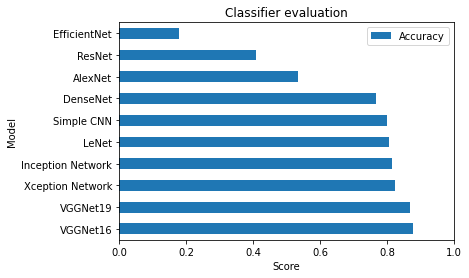

In [27]:
plt.figure(figsize=(7, 6))
log_models.plot.barh()
plt.title('Classifier evaluation')
#plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.xlabel('Score')
plt.xlim((0,1))
plt.show()

##### Validation loss vs epochs

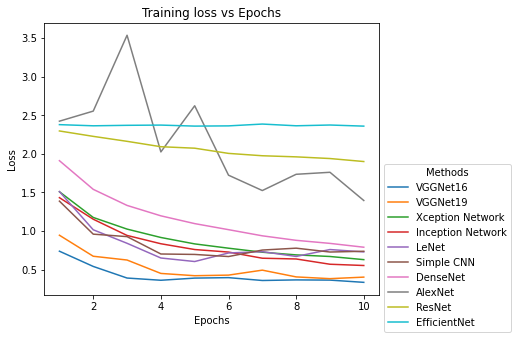

In [28]:
log_models = log_models.reset_index()
plt.figure(figsize=(6, 5))
for model in range(len(log_models)):
    plt.plot(range(1, 10+1), log_models['Validation Loss'][model], label=log_models['Model'][model])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Epochs')
plt.legend(title='Methods', bbox_to_anchor=(1, 0.5))
plt.show()
#log_models = log_models[['Model','Accuracy','Validation Loss']]

Based on the accuracy scores obtained, it can be concluded that the models VGGNet19 and VGGNet16 are performing the best among all the other models. Both models achieved an accuracy of over 83% on the validation set. The next best performing models are Simple CNN and LeNet, followed by Xception Network, DenseNet and Inception Network that performed moderately, while ResNet did not perform well compared to the other models. AlexNet and EfficientNet models performed very poorly in comparison to the other models.

Therefore, we will prefer to use VGGNet19 or VGGNet16 for this project, as they provide the highest accuracy.

However, it should be noted that we should also perform further testing with other parameters to ensure that these conclusions are robust. Additionally, other metrics beyond accuracy, such as precision, recall, and F1-score can gives us a more comprehensive understanding of the models' performance.